In [12]:
import requests
from pathlib import Path

# Define the path to the helper_functions.py file
file_path = Path("helper_functions.py")

# Check if the file exists
if file_path.is_file():
    # Open the file and read its content
    with open(file_path, "r") as file:
        content = file.read()
        # Check if the file contains invalid content (e.g., an HTML document)
        if "<!DOCTYPE html>" in content:
            print("Invalid content detected, deleting helper_functions.py")
            # Delete the file if it contains invalid content
            file_path.unlink()

# Check again if the file exists (it may have been deleted)
if not file_path.is_file():
    print("Downloading helper_functions.py")
    # Define the URL to download the file from
    url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    # Send a GET request to download the file
    response = requests.get(url)
    # Write the downloaded content to the file
    with open(file_path, "wb") as f:
        f.write(response.content)

# Import functions from the downloaded helper_functions.py file
from helper_functions import plot_predictions, plot_decision_boundary

Binary classification = one thing or another (cat vs. dog, spam vs. not spam, fraud or not fraud)

Multi-class classification = more than one thing or another (cat vs. dog vs. chicken)

### Creating a toy multi-class dataset

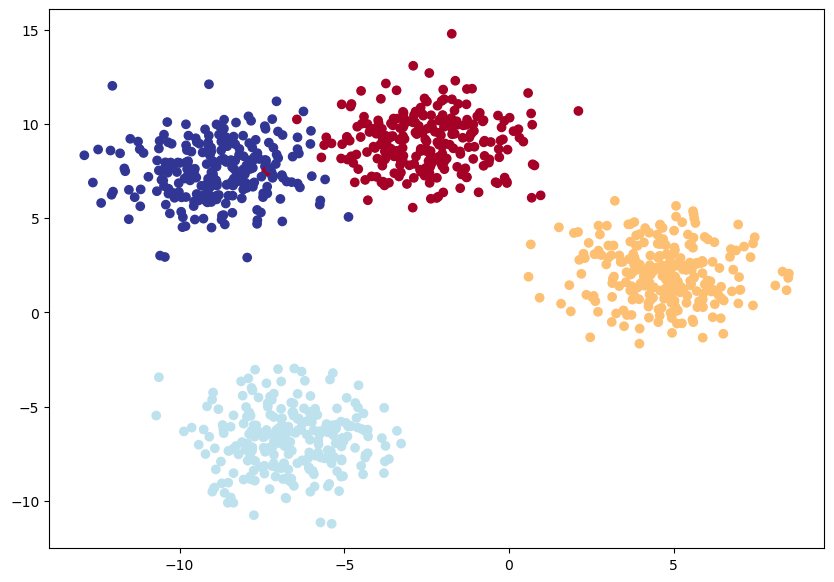

In [13]:
# Import necessary libraries for the rest of the code
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the number of classes, features, and random seed for reproducibility
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create a synthetic dataset with multiple classes using make_blobs
X_blob, Y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# Convert the dataset to PyTorch tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
Y_blob = torch.from_numpy(Y_blob).type(torch.float)

# Split the dataset into training and test sets
X_blob_train, X_blob_test, Y_blob_train, Y_blob_test = train_test_split(X_blob, Y_blob, test_size=0.2, random_state=RANDOM_SEED)

# Plot the entire dataset to visualize the different classes
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=Y_blob, cmap=plt.cm.RdYlBu)
plt.show()

# Check if MPS (Metal Performance Shaders) is available and set the device accordingly
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [14]:
# Define a neural network model class
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        # Create a stack of linear layers and ReLU activation functions
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    # Define the forward pass
    def forward(self, x):
        return self.linear_layer_stack(x)

# Initialize the model with the specified input and output features
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [15]:
# Create a loss function for multi class classification - loss function measures how wrong our model's prediction are
loss_fn = nn.CrossEntropyLoss()

# Create a optimizer for multi class classification - optimizer updates our model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(),lr=0.1)

### Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logtis) to predicition probabilities and then to prediction labels.

Logits (raw output of the model) -> Pred probs (use torch.softmax) -> Pred labels (take the argmax of the prediction probabilities)

In [16]:
# Evaluate the model on the test data without updating the parameters
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

# Print the first 10 logits (raw outputs)
print(y_logits[:10])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='mps:0')


In [17]:
# Apply the softmax function to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Print the first 5 logits and their corresponding probabilities
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='mps:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='mps:0')


In [18]:
# Get the predicted classes by taking the argmax of the probabilities
y_preds = torch.argmax(y_pred_probs, dim=1)

# Print the predicted classes and the true labels
print(y_preds)
print(Y_blob_test)

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='mps:0')
tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0., 0., 1., 0., 0., 0., 3., 3., 2.,
        3., 3., 3., 0., 1., 2., 2., 2., 3., 0., 1., 0., 3., 1., 1., 3., 1., 2.,
        1., 3., 0., 2., 0., 3., 3., 2., 0., 3., 1., 1., 0., 3., 1., 0., 1., 1.,
        3., 2., 1., 1., 3., 2., 2., 0., 3., 2., 2., 0., 0., 3., 3., 0.,

### Creating a training loop and testing loop for a multi-class PyTorch model

In [19]:
# Set manual seeds for reproducibility
torch.manual_seed(42)
torch.mps.manual_seed(42)

# Define an accuracy function
def accuracy_fn(y_true, y_pred):
    correct = (y_true == y_pred).sum().item()
    return (correct / len(y_true)) * 100

# Set the number of training epochs
epochs = 100

# Move the training and test data to the selected device
X_blob_train, Y_blob_train = X_blob_train.to(device), Y_blob_train.to(device)
X_blob_test, Y_blob_test = X_blob_test.to(device), Y_blob_test.to(device)

# Training loop
for epoch in range(epochs):
    # Set the model to training mode
    model_4.train()

    # Forward pass
    y_logits = model_4(X_blob_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # Calculate the loss and accuracy for the training data
    loss = loss_fn(y_logits, Y_blob_train)
    acc = accuracy_fn(y_true=Y_blob_train, y_pred=y_preds)

    # Zero the gradients, perform backpropagation, and update the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluate the model on the test data
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # Calculate the loss and accuracy for the test data
        test_loss = loss_fn(test_logits, Y_blob_test)
        test_acc = accuracy_fn(y_true=Y_blob_test, y_pred=test_preds)

    # Print the training and test metrics every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.1588, Acc: 40.38% | Test Loss: 1.0755, Test Acc: 48.00%
Epoch: 10 | Loss: 0.6448, Acc: 96.75% | Test Loss: 0.6607, Test Acc: 97.50%
Epoch: 20 | Loss: 0.4254, Acc: 98.50% | Test Loss: 0.4307, Test Acc: 100.00%
Epoch: 30 | Loss: 0.2529, Acc: 99.12% | Test Loss: 0.2451, Test Acc: 99.50%
Epoch: 40 | Loss: 0.1123, Acc: 99.25% | Test Loss: 0.1023, Test Acc: 99.50%
Epoch: 50 | Loss: 0.0663, Acc: 99.25% | Test Loss: 0.0585, Test Acc: 99.50%
Epoch: 60 | Loss: 0.0507, Acc: 99.25% | Test Loss: 0.0429, Test Acc: 99.50%
Epoch: 70 | Loss: 0.0430, Acc: 99.25% | Test Loss: 0.0349, Test Acc: 99.50%
Epoch: 80 | Loss: 0.0384, Acc: 99.25% | Test Loss: 0.0299, Test Acc: 99.50%
Epoch: 90 | Loss: 0.0352, Acc: 99.25% | Test Loss: 0.0266, Test Acc: 99.50%


### Making and evaluating predictions with a PyTorch multi-class model

In [20]:
# Final evaluation on the test set
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# Print the first 10 logits (raw outputs) for the test set
print(y_logits[:10])

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9465],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3762, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='mps:0')


In [21]:
# Apply the softmax function to get prediction probabilities for the test set
y_pred_probs = torch.softmax(y_logits, dim=1)

# Print the first 10 probabilities for the test set
print(y_pred_probs[:10])

# Get the predicted classes for the test set by taking the argmax of the probabilities
y_preds = torch.argmax(y_pred_probs, dim=1)

# Print the first 10 predicted classes for the test set
print(y_preds[:10])

tensor([[1.3437e-03, 9.9865e-01, 1.2163e-06, 5.3854e-07],
        [4.9905e-03, 7.4739e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6059e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1955e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4903e-06, 2.2377e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5043e-04],
        [9.9825e-01, 1.4575e-03, 1.5997e-05, 2.7210e-04]], device='mps:0')
tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')


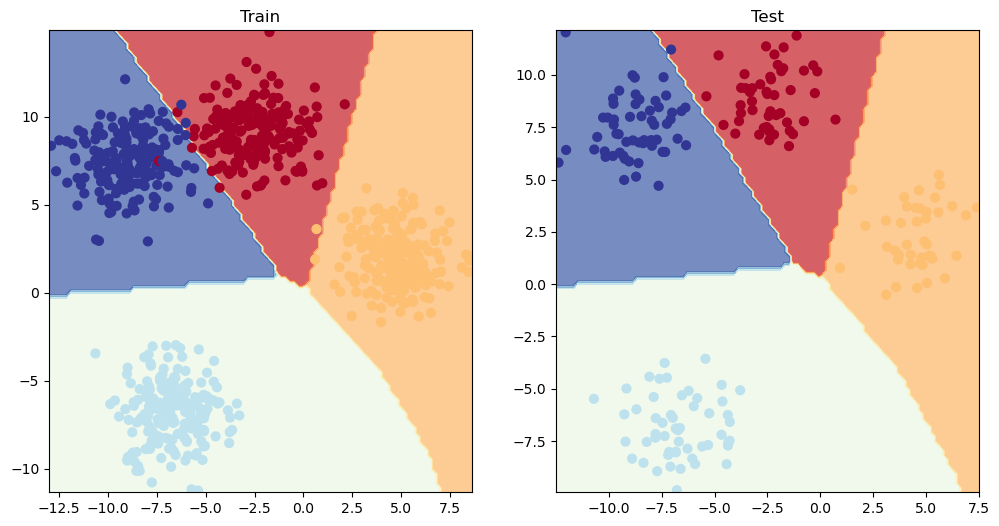

In [22]:
# Plot the decision boundaries for the training and test sets

# Create a new figure for plotting with a specified size (12 inches wide, 6 inches tall)
plt.figure(figsize=(12, 6))

# Create a subplot for the training set
# 1, 2, 1 means 1 row, 2 columns, and this is the 1st subplot
plt.subplot(1, 2, 1)

# Set the title of the first subplot to "Train"
plt.title("Train")

# Plot the decision boundary for the training set
# model_4 is the trained model
# X_blob_train is the training data
# Y_blob_train is the training labels
plot_decision_boundary(model_4, X_blob_train, Y_blob_train)

# Create a subplot for the test set
# 1, 2, 2 means 1 row, 2 columns, and this is the 2nd subplot
plt.subplot(1, 2, 2)

# Set the title of the second subplot to "Test"
plt.title("Test")

# Plot the decision boundary for the test set
# model_4 is the trained model
# X_blob_test is the test data
# Y_blob_test is the test labels
plot_decision_boundary(model_4, X_blob_test, Y_blob_test)

# Display the plots
plt.show()
